# Extract point embeddings for visualization from the FORAge train dataset split. 
- Can be used to create t-SNE plots for entire tree to map against age bins or species (1)
- Can be used to create point clouds of the train split with mean for each points feature embedding (2) 

## SETUP

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
from tqdm import tqdm

import sys 
sys.path.append('..')

from data_yours import FORAGE
from model_yours import MAE3D

from pathlib import Path
import pandas as pd 

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

**SET CONFIG IN THE FOLLOWING**

In [29]:
# get hydra config 
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

if GlobalHydra.instance().is_initialized():
	GlobalHydra.instance().clear()
	
initialize(config_path="../config/experiments")
cfg = compose(config_name="/BASELINE_FORSPECIES_RANDOM") # SET CONFIG HERE
OmegaConf.set_struct(cfg, False)

/tmp/ipykernel_2377772/2188953746.py:9: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../config/experiments")


In [30]:

experiment_dir = Path(f'../experiments/{cfg.experiment_setup.name}')


In [31]:
experiment_dir

PosixPath('../experiments/baseline_rand_patching_forspecies')

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [33]:
# load the pretrained model and load checkpoint 
model = MAE3D(cfg.model)
model = model.to(device)
checkpoint = torch.load(experiment_dir / 'checkpoints' /f'pretrained.pth', map_location=device)
model.load_state_dict(checkpoint) # change for other training runs

# select only the patch embedding layer 
emb_module = model.encoder.patch_embed
encoder = model.encoder

/tmp/ipykernel_2377772/1345823384.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(experiment_dir / 'checkpoints' /f'pretrained.pth', map_location

In [34]:
# set both to eval and move to device 
emb_module.eval()
encoder.eval()

# get the dataset 
process_loader = DataLoader(
    FORAGE(),
    batch_size=4,
    shuffle=False,
    drop_last=False,
)

In [35]:
# lists to store embeddings and labels 
emb_patch_module = [] 
labels_list = []
species_list = []
data_list = []

with torch.no_grad(): 
    for batch in tqdm(process_loader, desc="Processing batches"):
        data, labels, species = batch
        data = data.permute(0, 2, 1)
        data = data.to(device).float()
        labels = labels.to(device)

        # get the embeddings from the patch embedding module 
        emb_patch = emb_module(data)
        emb_patch_module.append(emb_patch.cpu().numpy())

        # get the labels 
        labels_list.append(labels.cpu().numpy())
        species_list.append(species.cpu().numpy())
        data_list.append(data.cpu().numpy())

Processing batches: 100%|██████████| 313/313 [00:24<00:00, 12.60it/s]


In [36]:
emb_patch_module = np.concatenate(emb_patch_module, axis=0)

In [37]:
emb_patch_module.shape

(1250, 1024, 2048)

## (1): t-SNE for age bins and species 

In [38]:
pooled_emb_patch_module = np.mean(emb_patch_module, axis=2)

In [39]:
pooled_emb_patch_module.shape

(1250, 1024)

In [40]:
from sklearn.manifold import TSNE

In [41]:
t_SNE_embeding = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=40).fit_transform(pooled_emb_patch_module)

In [42]:
import pandas as pd

In [43]:
df_emb_module = pd.DataFrame(t_SNE_embeding, columns=['x', 'y'])
df_emb_module['age'] = np.concatenate(labels_list, axis=0)

In [44]:
age_bins = np.linspace(0, 150, 10)
df_emb_module['age_bin'] = pd.cut(df_emb_module['age'], bins=age_bins, labels=False)

In [45]:
df_emb_module['species'] = np.concatenate(species_list, axis=0)

In [46]:
df_emb_module

,x,y,age,age_bin,species
0,-21.086210,-7.172719,62.0,3.0,1
1,-8.597809,-35.750912,53.0,3.0,1
2,-11.348868,-32.342190,54.0,3.0,1
3,-18.184351,-9.432697,56.0,3.0,1
4,-18.231258,-22.188400,62.0,3.0,1
...,...,...,...,...,...
1245,-1.754502,31.290188,13.0,0.0,1
1246,-12.700980,2.733319,29.0,1.0,0
1247,-4.306659,-23.702314,27.0,1.0,0
1248,-2.504829,-7.365222,35.0,2.0,0


In [47]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_style("ticks")

plt.rcParams.update({
	"axes.titlesize": 16,
	"axes.labelsize": 14,
	"xtick.labelsize": 12,
	"ytick.labelsize": 12,
	"legend.fontsize": 12,
	"font.family": "sans-serif",  # "serif", "sans-serif", "monospace"
	"figure.dpi": 300,
	"savefig.dpi": 300,
	"figure.figsize": (10, 6),
	"lines.linewidth": 2,
	"lines.markersize": 6,
	"axes.grid": True,
	"grid.linestyle": "--",
	"grid.alpha": 0.7
})

Text(0.5, 1.0, 't-SNE Patch embeddings random Patching')

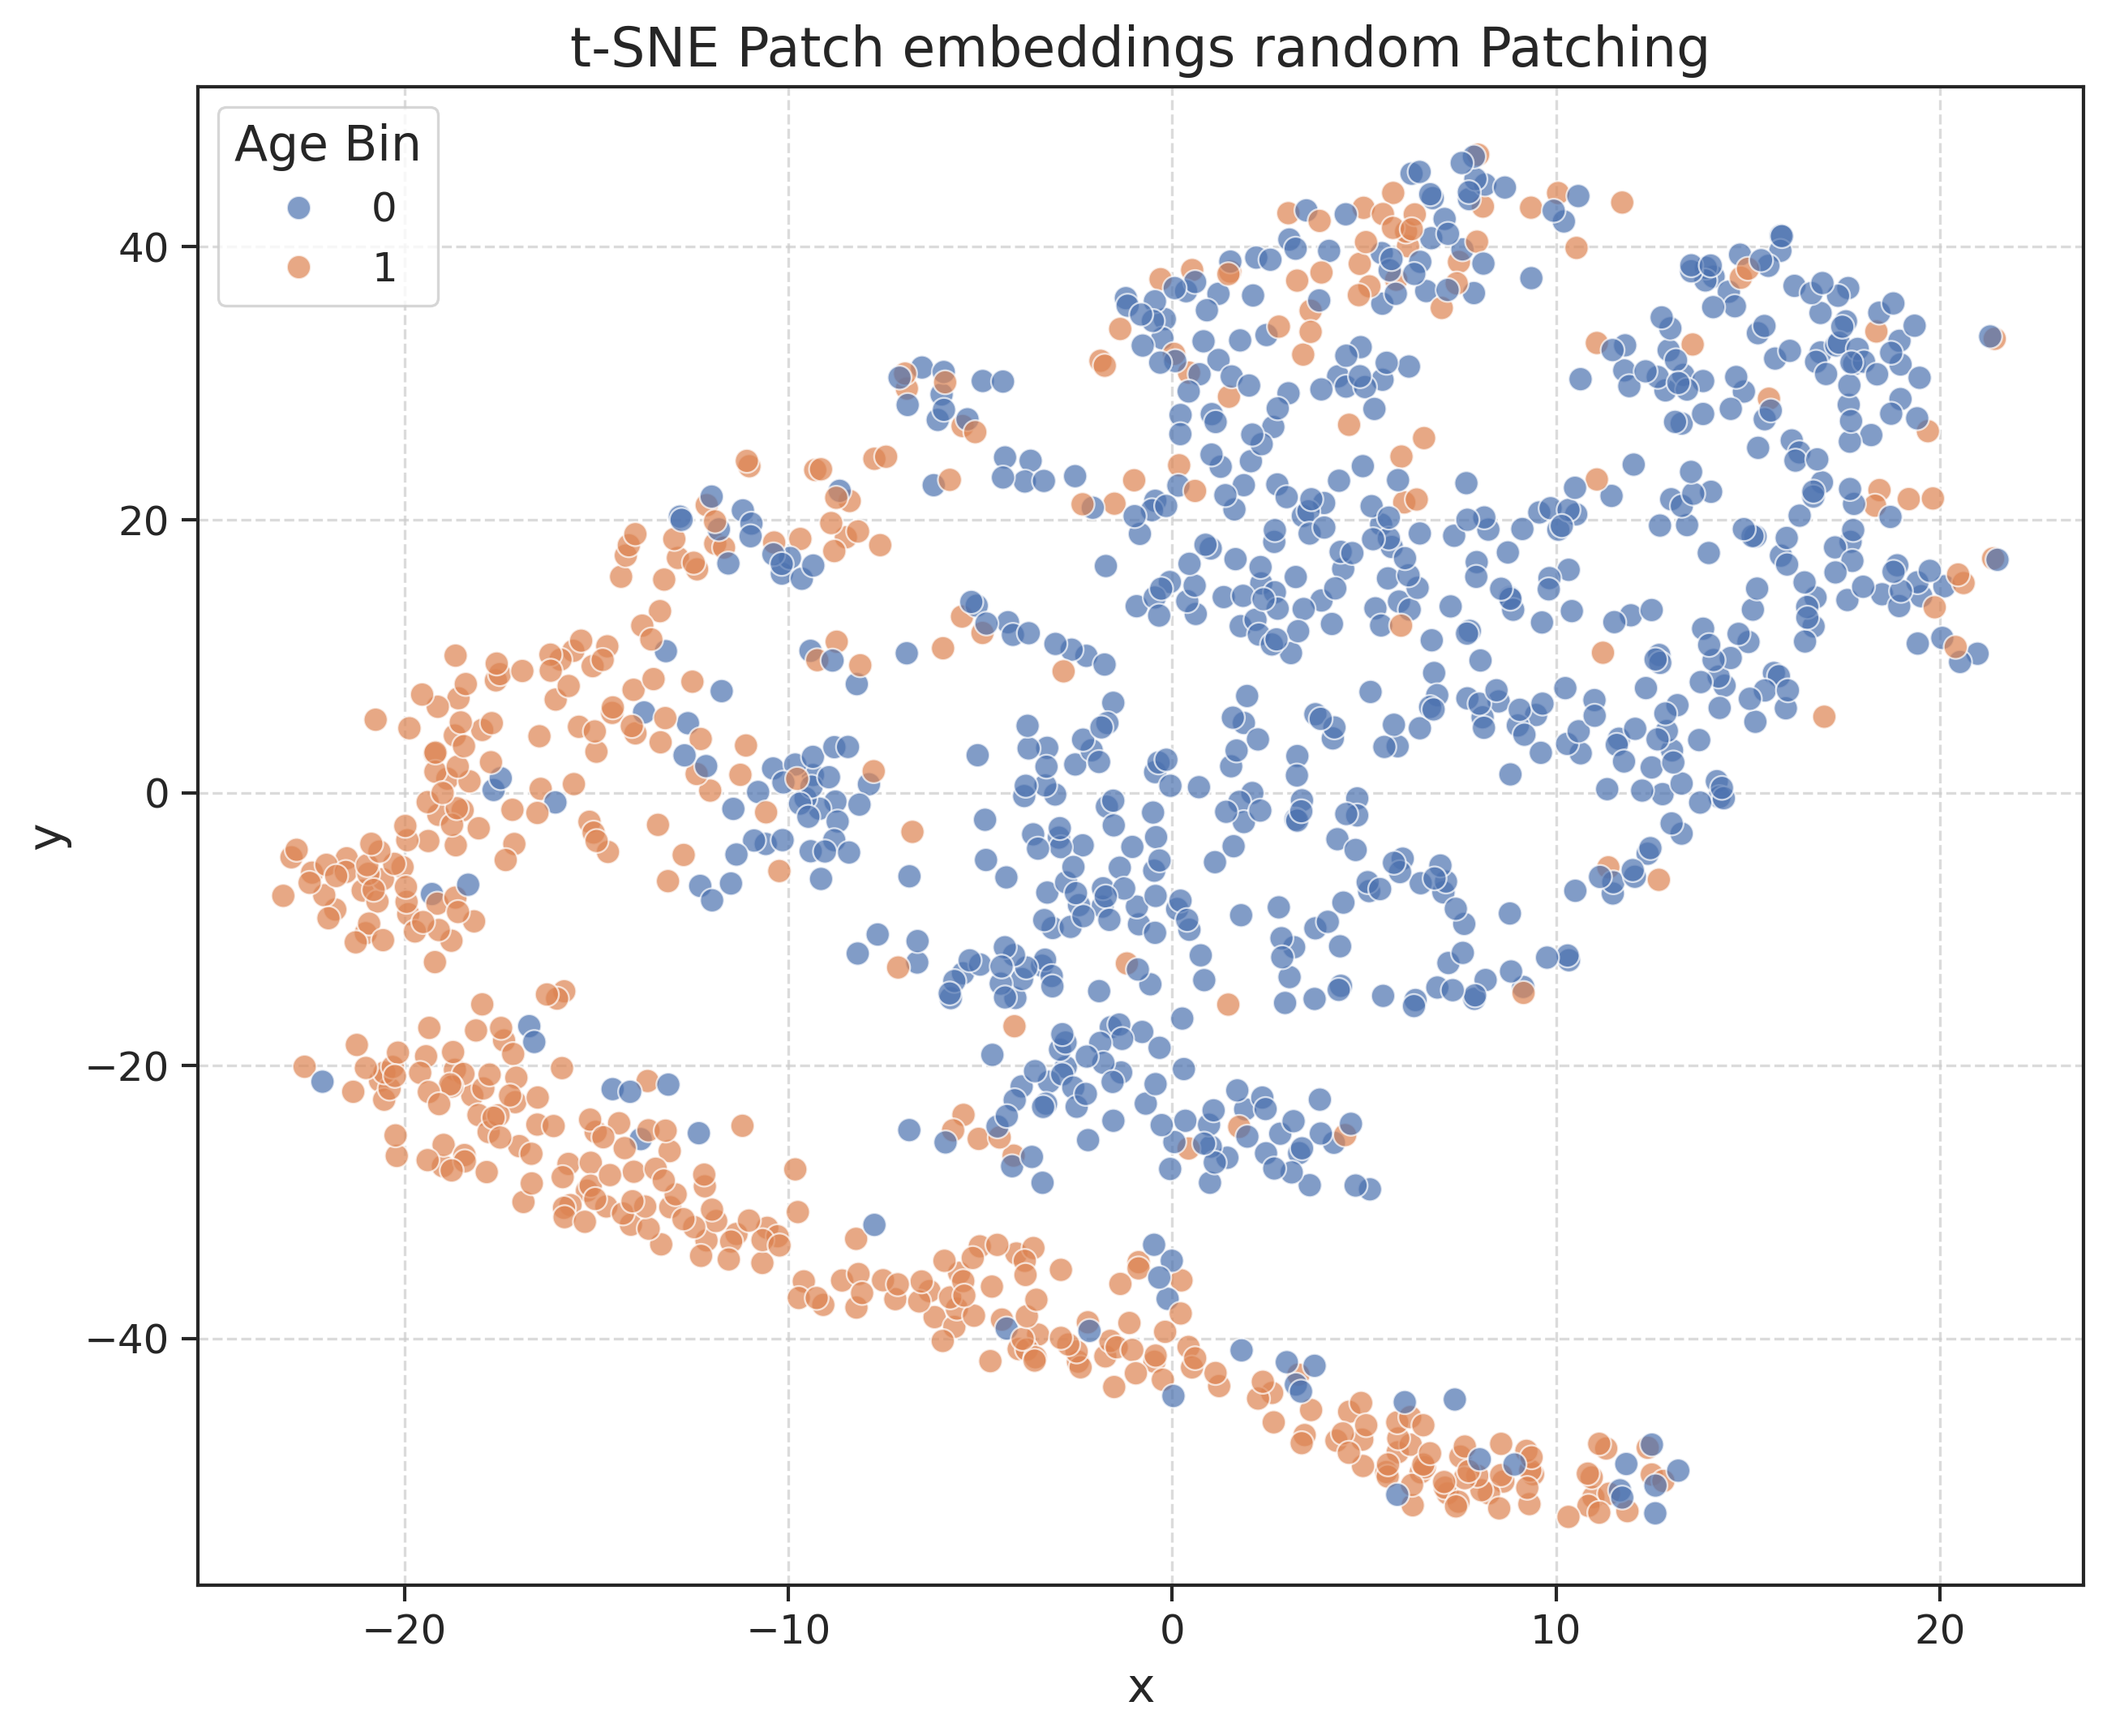

In [50]:
import seaborn as sns 
import matplotlib.pyplot as plt


cmap = plt.get_cmap('Accent')
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_emb_module, x='x', y='y', hue='species', s=50, alpha=0.7)
plt.legend(title='Age Bin')
plt.title('t-SNE Patch embeddings random Patching')

## (2): t-SNE for points 

In [99]:
data = np.concatenate(data_list, axis=0).transpose(0, 2, 1)
data.shape

(1250, 2048, 3)

In [100]:
data.shape

(1250, 2048, 3)

In [101]:
pooled_emb_patch_module = np.mean(emb_patch_module, axis=1)
pooled_emb_patch_module.shape

(1250, 2048)

In [102]:
# calculate age and age bins to select samples from each group 
df_age = pd.DataFrame(np.concatenate(labels_list, axis=0), columns=['age'])
age_bins = np.append(np.linspace(0, 150, 10), np.inf)
print(age_bins)

df_age['age_bin'] = pd.cut(df_age['age'], bins=age_bins, labels=False)

[  0.          16.66666667  33.33333333  50.          66.66666667
  83.33333333 100.         116.66666667 133.33333333 150.
          inf]


In [103]:
df_sampled = df_age.groupby('age_bin', group_keys=False).sample(n=10, random_state=42)

In [104]:
# indices to select from 
idx = df_sampled.index.values

In [105]:
# path to save pc_with_emb 
output_path = experiment_dir / 'visualization' / 'pc_with_emb' / 'pretrained' 
output_path.mkdir(parents=True, exist_ok=True)

In [106]:
for i in tqdm(idx, desc="Saving point clouds with embeddings"):
    # get the data and embedding 
    data_i = data[i, :]
    emb_i = pooled_emb_patch_module[i, :]

    # concat 
    data_i = np.concatenate([data_i, emb_i[:, None]], axis=1)

    # get age and age bin 
    age_i = df_age.iloc[i]['age']
    age_bin_i = df_age.iloc[i]['age_bin']

    # save the point cloud with embedding 
    np.savetxt(
        output_path / f'{i}_age_{int(age_i)}_bin_{int(age_bin_i)}.txt',
        data_i,
        delimiter=','
        )

Saving point clouds with embeddings: 100%|██████████| 100/100 [00:01<00:00, 85.21it/s]
